# 목적
* 크롤링 결과로 네트워크분석
* [참고](https://foreverhappiness.me/38)


# 선행설치

In [1]:
# 선행설치
# # 크롤링
# !pip install beautifulsoup4
# !pip install requests
# !pip install lxm
# # 연관분석
# !pip install apyori
# # 자연어처리
# !pip install konlpy (JDK 설치가 되어있어야함 )
# # 워드클라우드
# !pip install wordcloud

In [27]:
# import
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
import operator

from tqdm import tqdm_notebook  # 진행과정 시각화
from datetime import timedelta  # 시간날짜

import datetime
import pandas as pd
import numpy as np

import konlpy
from konlpy.tag import Komoran,Kkma,Okt,Twitter  # 자연어처리
# from eunjeon import Mecab #은전한닢 mecab을 설치하면 먹통이됨 2020-04-10 10:10:10 작동안됨
# import MeCab # meacb 별도설치 2020-04-10 10:10:10 작동안됨
import kss

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

okt = Okt()

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important; }</style>'))

In [17]:
def tokenized(tagger, dataframe, keyword, stopword, unique=False, save=True):
    '''
    tagger : 형태소분석기 무엇사용?
    dataframe : 분석할 df
    keyword : sw에 추가하기 위함
    '''

    # 단어빈도분석
    sw.append(keyword.split(' ')[0])
    all_words =[]

    for blog_num in tqdm_notebook(range(0,len(dataframe)),desc = 'tokenize'):
    #블로그 품사태깅 (load한 경우 list가 아닌 text로 받아서 첫번째가 아닌 전체를 받는다)
#     pos_text = okt.pos(target[blog_num][0], norm=True, stem=True)
        pos_text = tagger.pos(dataframe['full_text'][blog_num], norm=True, stem=True)

        pos_text_df = pd.DataFrame(pos_text)
        words = pos_text_df[pos_text_df[1].apply(lambda x : (x in "Noun") | (x in "Adjective"))][0].values
        clean_words = list(filter(lambda word : (len(word)>1)&(word not in sw),words))

        if unique == True:
            clean_words = list(set(clean_words))
        all_words.append(clean_words)
    return all_words

In [36]:
def networkx_graph(all_words, keyword, count_min = 100, min_cuple = 100, unique=False, save=True):
    '''
    tagger : 형태소분석기 무엇사용?
    dataframe : 분석할 df
    keyword : sw에 추가하기 위함
    
    '''
    import matplotlib.font_manager as fm
    
    corpus = list(map(lambda words : " ".join(words),all_words))
    #DTM
    vector = CountVectorizer()
    vector.fit(corpus) #코퍼스로부터 각 단어의 빈도 수를 기록한다.
    values = vector.transform(corpus).toarray()
    cols = vector.get_feature_names() # 각 단어의 인덱스가 어떻게 부여되었는지를 보여준다.
    DTM_df = pd.DataFrame(values,columns= cols)
    
    #count_min이하의 단어는 배제 
    del_cols = DTM_df.sum()[DTM_df.sum()<count_min].index.values
    DTM_df = DTM_df.drop(del_cols,axis=1)
    cols = DTM_df.columns.values
    word_length = len(cols)
    
    #단어쌍 계산
    count_dict = {}
    for doc_num in tqdm_notebook(range(len(DTM_df)),desc = '단어쌍'):
        tmp = DTM_df.loc[doc_num] #현재문서의 단어 출현 빈도
        for i, word1 in enumerate(cols):
            if tmp[word1]: #현재문서에 첫번째 단어가 존재할 경우
                for j in range(i+1, word_length):
                    if tmp[cols[j]]:
                        count_dict[cols[i], cols[j]] = count_dict.get((cols[i],cols[j]), 0) + max(tmp[word1],tmp[cols[j]])

    count_list = []
    for words in count_dict:
        count_list.append([words[0],words[1],count_dict[words]])
    df = pd.DataFrame(count_list, columns = ['word1','word2','freq'])
    df = df.sort_values(by='freq',ascending= False)
    df.reset_index(drop =True,inplace = True)
    
    #network
    G_centrality = nx.Graph() #중심성척도계산을 위한 그래프
    for ind in range((len(np.where(df['freq'] >=min_cuple)[0]))):
        G_centrality.add_edge(df['word1'][ind],df['word2'][ind], weight = int(df['freq'][ind])) #word1,word2간의 빈도수를 갖는 edge생성 
    dgr = nx.degree_centrality(G_centrality) #연결중심성(직접적으로 연결된 노드의수 )
   
    #중심성이 큰순으로 정렬 
    sorted_dgr = sorted(dgr.items(),key=operator.itemgetter(1), reverse = True)
  
    #네트워크 그릴 그래프 선언
    G = nx.Graph()
    
    #페이지 랭크에 따라 두 노드사이 연관성 결정
    for i in range(len(sorted_dgr)):
        G.add_node(sorted_dgr[i][0], nodesize = sorted_dgr[i][1])
    for ind in range((len(np.where(df['freq']>=min_cuple)[0]))):
        G.add_weighted_edges_from([(df['word1'][ind],df['word2'][ind],int(df['freq'][ind]))])
        
    #노드크기
    sizes = [G.nodes[node]['nodesize']*500 for node in G]
    
    #컬러, 라벨다는 것 등 
    options = {
        'edge_color' : '#FFDEA2',
        'node_color' : 'lightpink',
        'width':1,
        'with_labels':True,
        'font_weight':'regular'
    }
    #한글 설정
    fm._rebuild()
    font_fname = "c:/Windows/Fonts/malgun.ttf"
    fontprop = fm.FontProperties(fname=font_fname, size = 18).get_name()
    
    #그래프 생성
    plt.figure(figsize= (15,15))
    nx.draw(G,node_size=sizes, pos = nx.spring_layout(G, k=3.5, iterations= 100), **options, font_family=fontprop)
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#555555")
    plt.savefig("./output/네트워크분석/"+keyword+"_networkx.png")

In [5]:
# keyword검색시 "검색어 +필수어" 형태로 필수단어 삽입가능
today = datetime.datetime.today().date()
keyword = "양양 +강원도"
start_num = 1
end_num = 701
date_option = 8
date_from = "20150101"
date_to = "20151231"

In [6]:
#불용어
sw = list(set(['오늘', '시간', '최근', '지난', '관련', '이번', '이날', '현재', '10', '올해', '지난해', '있다', '이상', '기준', '때문',
               '메뉴', '강원도', '정도', '도착', '생각', '사진', '위치', '라고','아침', '저녁', '다음', '우리', '시작', '여기', '이곳', '사람',
               '여행','바다','해변','다시','역시','하루','이용','하나','준비','정말','바로','저희','한번','모습','마음','보고','아주','그냥','처음',
               '지도','보기','상세','전화','저장', '폴더', '가기','장소','팝업','레이스',"진짜","조금","위해",'모두',"어떻다","이제","출발",
              '이다', '많다','좋다','같다','없다','그렇다','이렇다','아니다','안녕하다','가능하다',
              "모두","가장","소개","추천","다른","방문","주변","자리","지금","포스팅","느낌",
            "지역","가지","직접","사용","입구","어떻다","날씨","타고","출발","이제","이다","사실",'가면','주문','근처',
              "양양군","양양"]))

# 데이터로드
* 크롤링된 결과를 가지고 진행한다

In [11]:
# 데이터로드
path = './output/20일 중복x 21일 중복o 비교/크롤링/'
crawling_df = pd.read_csv(path +'2020-04-21_양양 +강원도_811_20150101~20151231.csv')

In [9]:
crawling_df.head()

,post_dates,title,full_text,url
0,2015-06-01,쩡아네,[' 주말에 선우맘은 형님네랑 강원도 양양에 다녀왔어요 완전 맛있는 치킨 피자집을 ...,http://blog.naver.com/PostView.nhn?blogId=sin8...
1,2015-04-01,뭉가무자치의 캠핑여행,[' 뭉가무자치의 캠핑여행 자연휴양림 시설중에서 볼거리가 많은 모습이다. 산림문화...,http://blog.naver.com/PostView.nhn?blogId=sysz...
2,2015-01-01,지순이아범,[' [강원도 숙소]낙산 톡게스트하우스 속초/양양 강원도 양양 낙산 톡게스트하우스 ...,http://blog.naver.com/PostView.nhn?blogId=gv18...
3,2015-06-01,내가 행복한 이유,[' 강원도 양양 맛집 실로암 메밀국수에 또 다녀왔습니다. 너무 유명해서... 찾기...,http://blog.naver.com/PostView.nhn?blogId=neln...
4,2015-10-01,5479xodid님의블로그,[' 양양 강원도 기간 : 2015.10.03 2015.10.04 (1박 2일) ...,http://blog.naver.com/PostView.nhn?blogId=5479...


### 추출된 데이터 일자별 집중도 확인

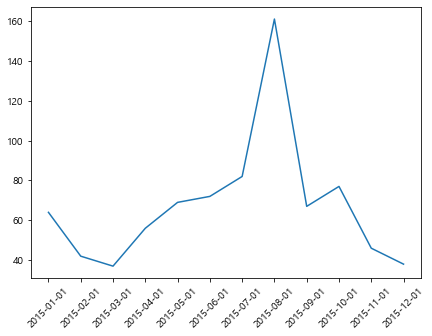

In [343]:
plt.figure(figsize=(7,5))
plt.plot(crawling_df['post_dates'].value_counts().sort_index())
plt.xticks(rotation = 45)
# plt.savefig("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_날짜빈도'+'.png')
plt.show()

In [ ]:
all_words = tokenized(okt,crawling_df,"양양",sw)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


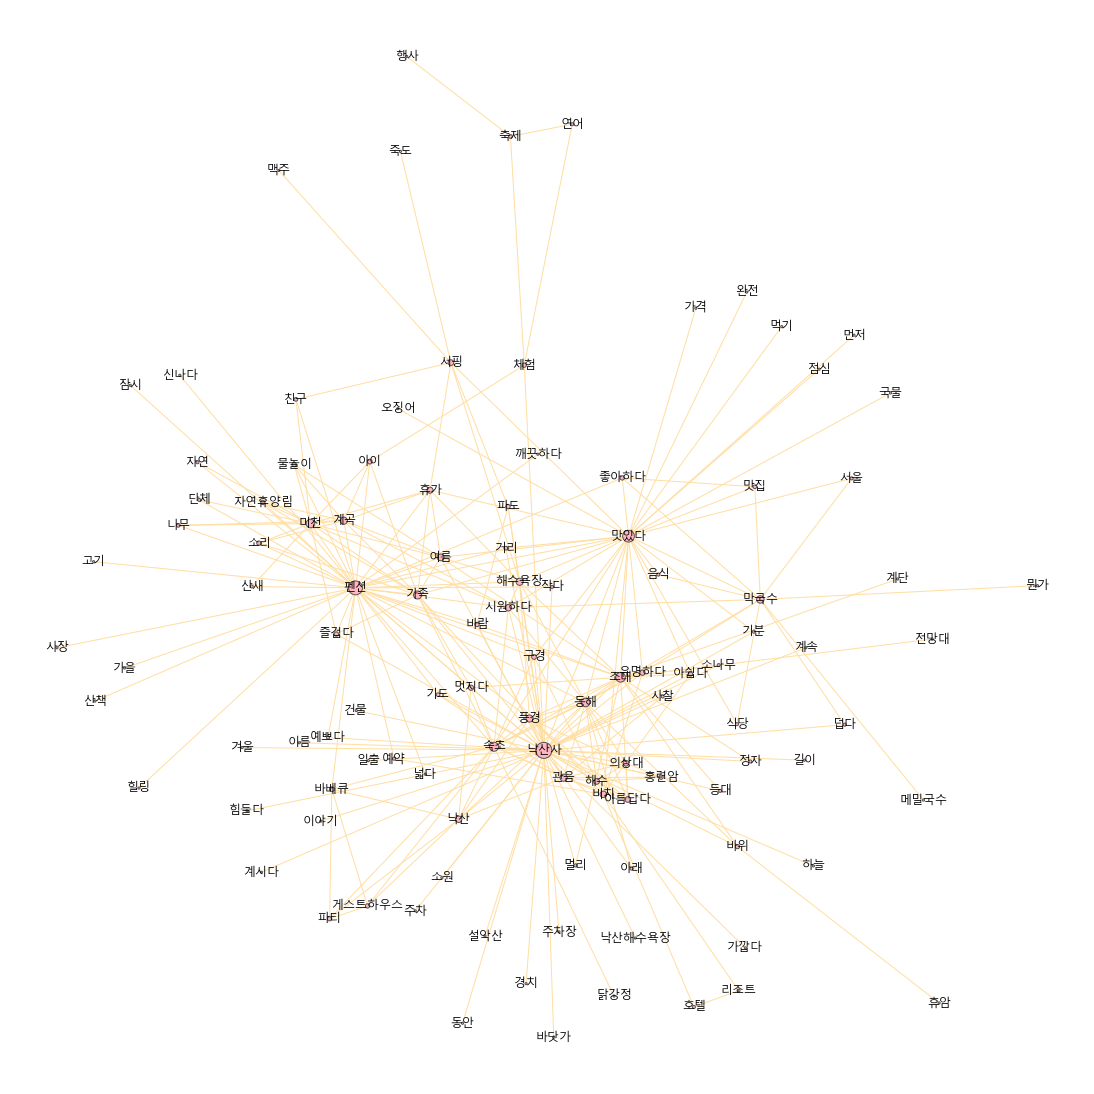

In [37]:
networkx_graph(all_words,"양양",min_cuple=150)